In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [5]:
!pip install razdel

In [6]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 2.6MB/s eta 0:00:011
     |████████████████████████████████| 8.2MB 3.7MB/s eta 0:00:01     |██▊                             | 696kB 3.7MB/s eta 0:00:03     |██████████▉                     | 2.8MB 3.7MB/s eta 0:00:02     |█████████████████████████▉      | 6.6MB 3.7MB/s eta 0:00:01
  Stored in directory: /home/alex/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built docopt


In [8]:
!pip install gensim

     |████████████████████████████████| 23.9MB 23.3MB/s eta 0:00:01   |█▍                              | 1.0MB 3.0MB/s eta 0:00:08     |█████▍                          | 4.0MB 3.0MB/s eta 0:00:07     |██████▎                         | 4.6MB 3.0MB/s eta 0:00:07     |████████▎                       | 6.2MB 3.0MB/s eta 0:00:06     |██████████▊                     | 8.0MB 3.0MB/s eta 0:00:06
     |████████████████████████████████| 122kB 48.4MB/s eta 0:00:01
  Stored in directory: /home/alex/.cache/pip/wheels/15/0f/9d/7e45b70ef6b849a97f74eb004fa9a350e7e496a6404805a8a1
Successfully built smart-open


In [6]:
!pip install nltk

     |████████████████████████████████| 1.4 MB 2.9 MB/s eta 0:00:01     |█████▎                          | 235 kB 2.9 MB/s eta 0:00:01     |█████████████████████████▉      | 1.2 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.9 MB/s eta 0:00:011
     |████████████████████████████████| 723 kB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 4.1 MB/s  eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434676 sha256=8fa4c0399b5d1f123ff2bc1612acbad589742ed7212814f644e71acfd1906e75
  Stored in directory: /home/alex/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk


In [7]:
from gensim.corpora.dictionary import Dictionary
import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize

import pymorphy2

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

morph = pymorphy2.MorphAnalyzer()

151


In [12]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 40.9 s, sys: 672 ms, total: 41.6 s
Wall time: 41.7 s


In [15]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 6min 46s, sys: 112 ms, total: 6min 47s
Wall time: 6min 47s


In [16]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

In [44]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [18]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 51.4 s, sys: 128 ms, total: 51.5 s
Wall time: 51.7 s


In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [50]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.07941285), (7, 0.23205315), (24, 0.6652269)]

In [21]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints O[(20,
#   '0.016*"памятник" + 0.015*"пресссекретарить" + 0.015*"украина" + 0.014*"белоруссия" + 0.013*"общество" + 0.013*"квартира" + 0.010*"путин" + 0.010*"nn" + 0.010*"песок" + 0.009*"владимир"')nly Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: nn высота медведев лаборатория специальный список способность
topic_1: планета мероприятие nn физика огонь сайт программа
topic_2: проект рынок россия российский новый глава развитие
topic_3: вирус устанавливать одежда устойчивость достопримечательность заболеть производитель
topic_4: фестиваль остров мышь япония nn таиланд золото
topic_5: фильм автобус сталкиваться фрагмент зима свет дневный
topic_6: операция снизить nn производитель действие законодательство террорист
topic_7: произойти погибнуть всё взрыв космос товар изз
topic_8: санкция власть россия мера эксперимент сотрудник орган
topic_9: млн составить доход доллар показатель рынок налог
topic_10: банк земля nn американский статья риск государство
topic_11: млрд рубль фонд экономика рост россия средство
topic_12: убийство долг следователь обвинение подозревать теория сотрудник
topic_13: научный университет болезнь студент миллиардер товарищ кольцо
topic_14: военный газ россия российский район смерть советский
topic_15:

In [22]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))
    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])

In [24]:
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values

In [25]:
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]

In [26]:
topic_matrix.head(3)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.385835,0.037752,0.299041,0.0,0.032242,0.000000,0.156885,0.000000,0.0,...,0.0,0.0,0.024066,0.0,0.0,0.042891,0.0,0.0,0.0,0.000000
1,4896,0.000000,0.000000,0.000000,0.0,0.000000,0.095101,0.000000,0.759578,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,4897,0.000000,0.079320,0.000000,0.0,0.000000,0.000000,0.000000,0.232166,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.665207


### Следующий шаг - векторные представления пользователей

In [27]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [28]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [29]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [30]:
get_user_embedding(user_articles_list)

array([0.00587756, 0.00860744, 0.14424897, 0.00218427, 0.        ,
       0.00616227, 0.03218904, 0.01451898, 0.02673033, 0.03145959,
       0.11756039, 0.05222989, 0.04618807, 0.        , 0.06593567,
       0.        , 0.09676756, 0.06508869, 0.        , 0.08967787,
       0.04674537, 0.03056523, 0.05718645, 0.03016619, 0.013927  ])

In [31]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.009299,0.030307,0.038835,0.0,0.046356,0.0000,0.018986,0.028387,0.020903,...,0.011769,0.242517,0.033264,0.004579,0.067116,0.007416,0.030396,0.062678,0.009507,0.053971
1,u108690,0.010293,0.002778,0.039607,0.0,0.005306,0.0076,0.072300,0.073314,0.061137,...,0.000000,0.118267,0.057366,0.000000,0.132324,0.019444,0.038002,0.044713,0.000000,0.021739
2,u108339,0.008834,0.015301,0.041985,0.0,0.000000,0.0000,0.033601,0.097220,0.060368,...,0.002355,0.083572,0.002354,0.000000,0.033887,0.030176,0.067021,0.032625,0.050109,0.047955


In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [33]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.009299,0.030307,0.038835,0.0,0.046356,0.0000,0.018986,0.028387,0.020903,...,0.242517,0.033264,0.004579,0.067116,0.007416,0.030396,0.062678,0.009507,0.053971,0
1,u108690,0.010293,0.002778,0.039607,0.0,0.005306,0.0076,0.072300,0.073314,0.061137,...,0.118267,0.057366,0.000000,0.132324,0.019444,0.038002,0.044713,0.000000,0.021739,1
2,u108339,0.008834,0.015301,0.041985,0.0,0.000000,0.0000,0.033601,0.097220,0.060368,...,0.083572,0.002354,0.000000,0.033887,0.030176,0.067021,0.032625,0.050109,0.047955,1


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [72]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=100)

In [73]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08398098, 0.16106948, 0.13449264, 0.11738133, 0.02894777,
       0.30489117, 0.0082155 , 0.01186235, 0.1256347 , 0.11676163])

### Рассчитаем Precision, Recall, F_score

In [38]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [75]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.266158, F-Score=0.555, Precision=0.563, Recall=0.546


In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
import itertools

Confusion matrix, without normalization
[[1630  110]
 [ 119  141]]


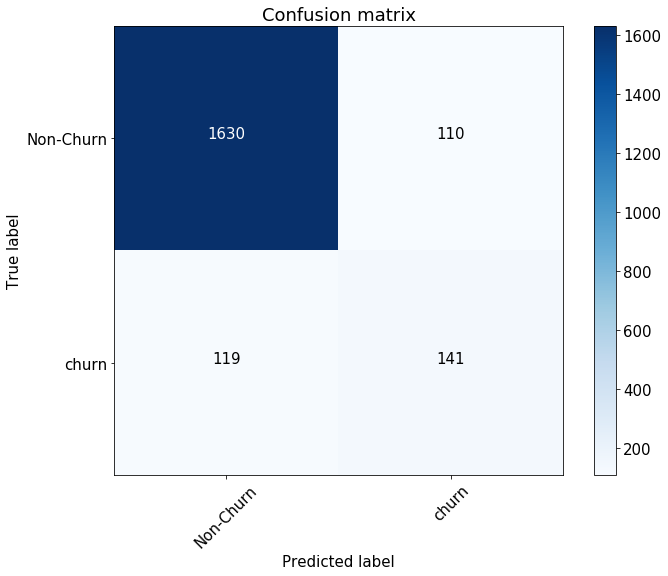

In [77]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [78]:
roc_auc_score(y_test, preds)

0.902075596816976

# Задание

In [79]:
def get_user_embedding_op(user_articles_list, op):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = op(user_vector, 0)
    return user_vector

In [83]:
def get_user_embeddings_op(data, op):
    user_embeddings = pd.DataFrame([i for i in data.apply(lambda x: get_user_embedding_op(x, op), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    return user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [91]:
def get_op_train_test_data(users, target, ops):
    train_test_data = []
    for op in ops:
        user_embeddings = get_user_embeddings_op(users['articles'], op)
        X = pd.merge(user_embeddings, target, 'left')
        X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                            X['churn'], random_state=100)
        train_test_data += [(X_train, X_test, y_train, y_test, op.__name__)]
    return train_test_data

In [98]:
ops = [np.mean, np.median, np.max]
logreg = LogisticRegression()

def handle_operations():
    result = {}
    for data in get_op_train_test_data(users, target, ops):
        X_train, X_test, y_train, y_test, op = data
        logreg.fit(X_train, y_train)
        preds = logreg.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
        cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
        
        result[op] = roc_auc, fscore[ix], precision[ix], recall[ix], cnf_matrix
    return result

In [102]:
results = pd.DataFrame(handle_operations())

In [106]:
results.index = ['roc_auc','f1_score','precision','recall', 'cnf_matrix']
results

,mean,median,amax
roc_auc,0.902076,0.958389,0.968853
f1_score,0.554687,0.735593,0.777778
precision,0.563492,0.657576,0.774809
recall,0.546154,0.834615,0.780769
cnf_matrix,"[[1630, 110], [119, 141]]","[[1627, 113], [44, 216]]","[[1681, 59], [58, 202]]"


In [278]:
results.to_csv('results.csv')

Лучшие результаты показывает метод использующий операцию max (кроме параметра recall). Возможно это говорит о том, что на пользователей в большей мере оказывают влияния статьи с ярко выраженной тематикой

### Попробуем исользовать tf-idf

In [244]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [252]:
vectorizer = TfidfVectorizer(token_pattern=r"\d+")

In [263]:
tfidf_matrix = vectorizer.fit_transform(users['articles'])

In [264]:
df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names())

Каждый пользователь читал определенную статью только один раз. Поэтому в нашем случае вхождения любого слова (id статьи) в документ (список статей пользователя) равно одному. 

In [265]:
article_weights = {}
for col in df.columns:
    article_weights[col] = df[df[col] != 0][col].mean()

In [271]:
def get_user_embedding_op_idf(user_articles_list, op):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] * article_weights[str(doc_id)] for doc_id in user_articles_list])
    user_vector = op(user_vector, 0)
    return user_vector

In [272]:
def get_user_embeddings_op_idf(data, op):
    user_embeddings = pd.DataFrame([i for i in data.apply(lambda x: get_user_embedding_op_idf(x, op), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    return user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [273]:
def get_op_train_test_data_idf(users, target, ops):
    train_test_data = []
    for op in ops:
        user_embeddings = get_user_embeddings_op_idf(users['articles'], op)
        X = pd.merge(user_embeddings, target, 'left')
        X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                            X['churn'], random_state=100)
        train_test_data += [(X_train, X_test, y_train, y_test, op.__name__)]
    return train_test_data

In [274]:
ops = [np.mean, np.median, np.max]
logreg = LogisticRegression()

def handle_operations():
    result = {}
    for data in get_op_train_test_data_idf(users, target, ops):
        X_train, X_test, y_train, y_test, op = data
        logreg.fit(X_train, y_train)
        preds = logreg.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
        cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
        
        result[op] = roc_auc, fscore[ix], precision[ix], recall[ix], cnf_matrix
    return result

In [276]:
results = pd.DataFrame(handle_operations())

In [277]:
results.index = ['roc_auc','f1_score','precision','recall', 'cnf_matrix']
results

,mean,median,amax
roc_auc,0.890619,0.945261,0.952829
f1_score,0.548957,0.680272,0.713781
precision,0.471074,0.609756,0.660131
recall,0.657692,0.769231,0.776923
cnf_matrix,"[[1548, 192], [90, 170]]","[[1612, 128], [61, 199]]","[[1636, 104], [59, 201]]"


Результаты c использованием tf-idf оказались незначительно хуже, чем без его использования. Вероятноэто связано с тем, что количество пересечений по статьям (когда одну татью читало много людей) небольшое и не оказывает существенного влияния на итоговые результаты